In [ ]:
!pip install pyspark

In [ ]:
!pip install dtreeviz

In [ ]:
import pyspark
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, MultilabelClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from xgboost.spark import SparkXGBRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
spark = SparkSession.builder.appName("myAppName").getOrCreate()


In [ ]:
df=spark.read.format("parquet").option("header", True).option("inferSchema", True).load('/content/drive/MyDrive/DISTRIBUTED/output.parquet')

In [ ]:
df=df.drop("FlightDate","Diverted","DivAirportLandings")


In [ ]:
# dad

In [ ]:
num_cols_cleaned = [item[0] for item in df.dtypes if item[1] != 'string']
print('Le colonne numeriche sono')
print(num_cols_cleaned)

Le colonne numeriche sono
['Cancelled', 'DepDelay', 'AirTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'DestAirportID', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups', 'DistanceGroup', 'DepTime', 'ArrTime', 'WheelsOff', 'WheelsOn', 'scaled_DepDelay', 'scaled_AirTime', 'scaled_Distance', 'scaled_ArrDelay', 'scaled_DepTime_InMinutes', 'scaled_ArrTime_InMinutes', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes']


In [ ]:
df_correlation=df.select(['Cancelled', 'DepDelay', 'AirTime', 'Distance', 'Month', 'DayofMonth', 'DayOfWeek', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'DestAirportID', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups', 'DistanceGroup', 'DepTime', 'ArrTime', 'WheelsOff', 'WheelsOn', 'scaled_DepDelay', 'scaled_AirTime', 'scaled_Distance', 'scaled_ArrDelay', 'scaled_DepTime_InMinutes', 'scaled_ArrTime_InMinutes', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes'])

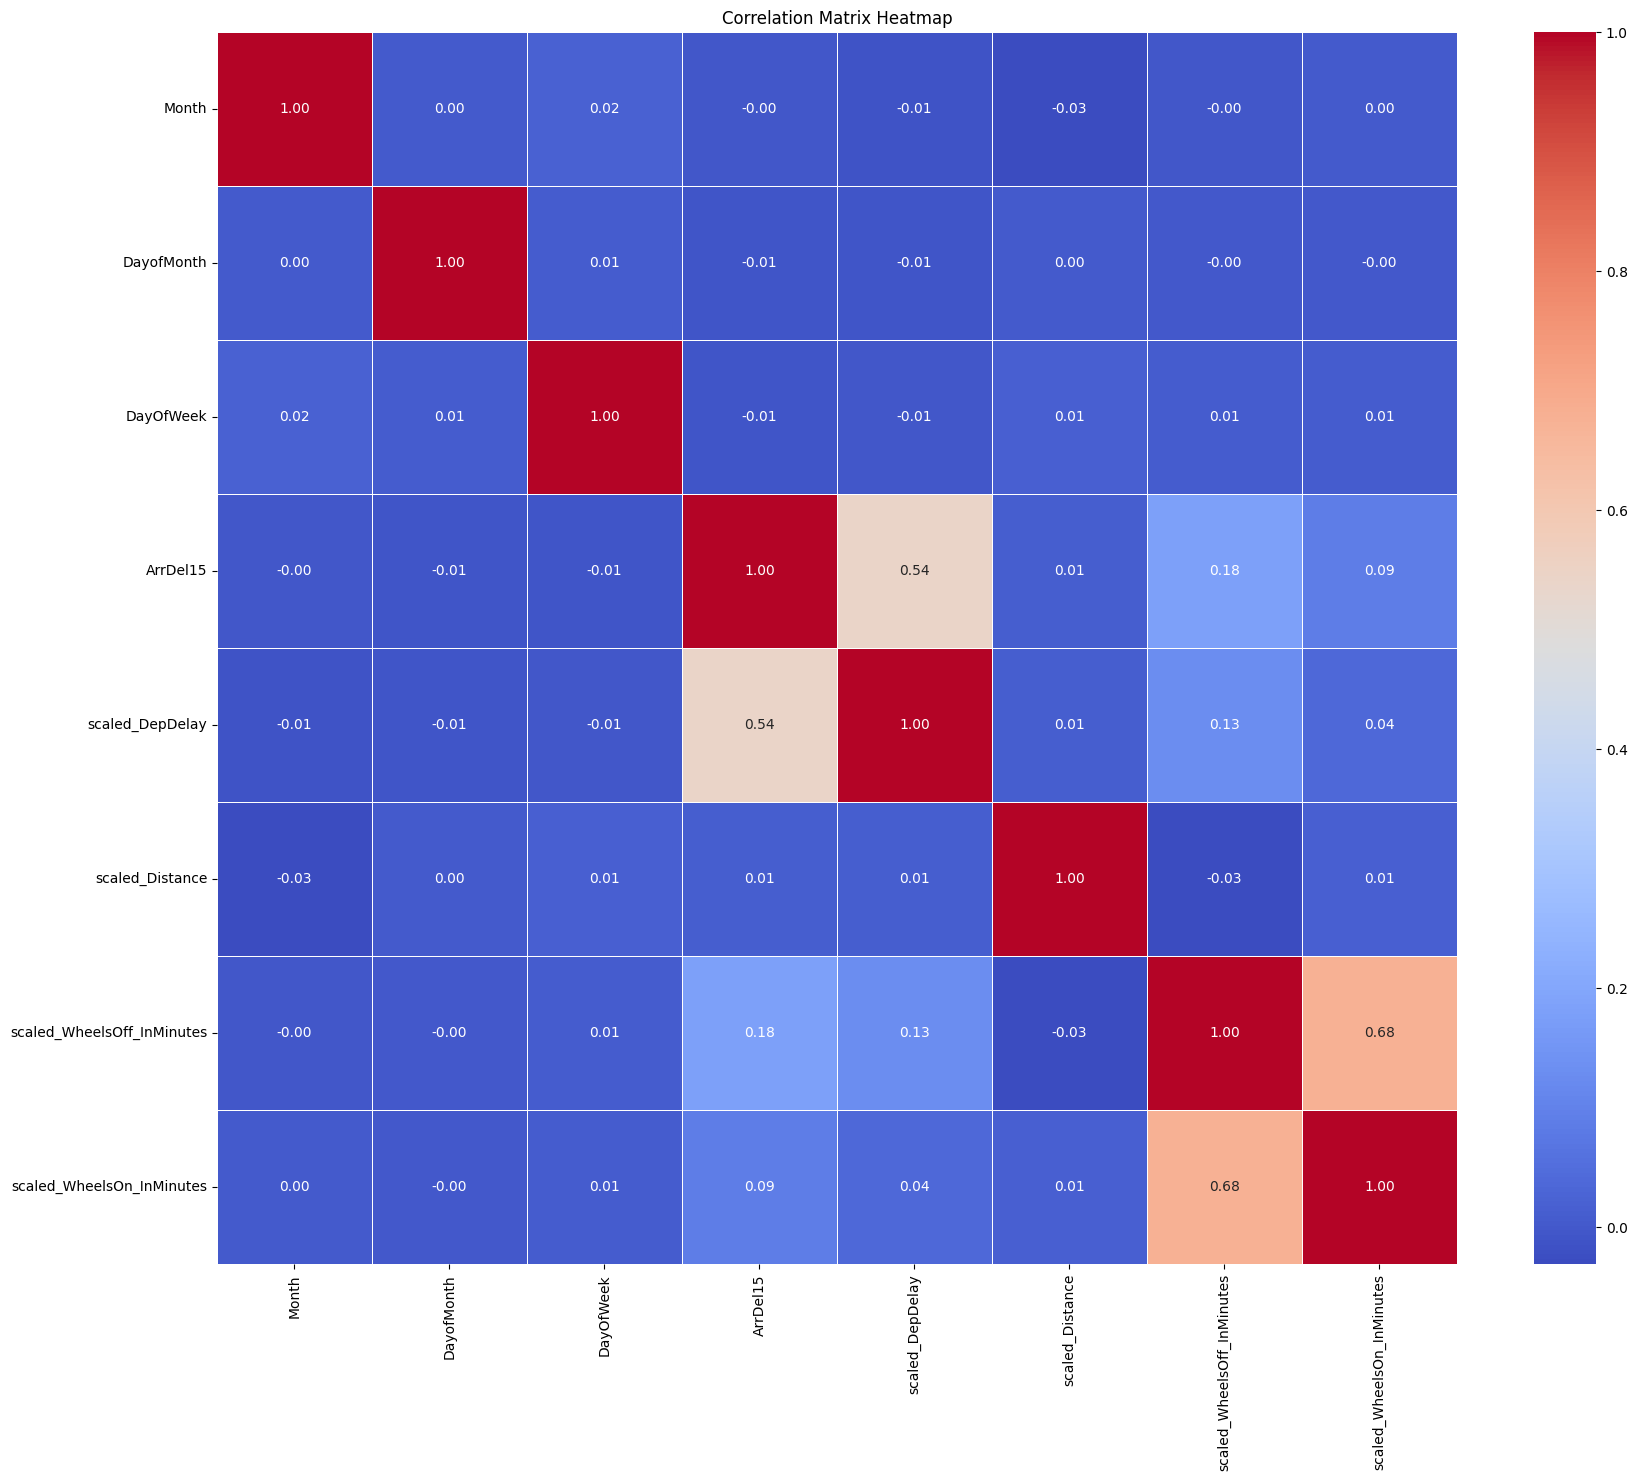

In [ ]:
from pyspark.ml.stat import Correlation


# Select numerical columns for correlation analysis
numerical_columns = [col for col in df_correlation['Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15', 'scaled_DepDelay', 'scaled_Distance', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes'].columns]

vec_assembler_corr = VectorAssembler(inputCols=numerical_columns, outputCol='features')

# Transform the DataFrame
df_numerical_corr = vec_assembler_corr.transform(df_correlation).select('features')

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_numerical_corr, 'features').head()

# Extract the correlation matrix as a NumPy array
corr_matrix = correlation_matrix[0].toArray()

# Convert the correlation matrix to a Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix, columns=numerical_columns, index=numerical_columns)

# Plot the correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
df.show()

+--------------------+------+----+---------+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
|             Airline|Origin|Dest|Cancelled|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|OriginAirportID|      OriginCityName|OriginStateName|DestAirpor

Some columns are One Hot encodate in order to make the future processing of the algorithm of them possible. Through StringIndexer function we convert the columns of strings into columns of numerical indexes.

In [ ]:
df = df.withColumn("Cancelled", df["Cancelled"].cast("string"))

Definisco un nuovo dataframe per la regressione

In [ ]:
df_regress= df.select('Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15', 'scaled_DepDelay', 'scaled_Distance', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes')

In [ ]:
df_regress.show()

+-----+----------+---------+--------+-------------------+--------------------+--------------------------+-------------------------+
|Month|DayofMonth|DayOfWeek|ArrDel15|    scaled_DepDelay|     scaled_Distance|scaled_WheelsOff_InMinutes|scaled_WheelsOn_InMinutes|
+-----+----------+---------+--------+-------------------+--------------------+--------------------------+-------------------------+
|    1|        18|        4|     0.0|0.32701664532650443| 0.34592084006462037|        0.3933287004864489|       0.4642112578179291|
|    3|        18|        7|     0.0|0.32676056338028164|  0.5098949919224556|        0.6879777623349548|       0.8054204308547602|
|    4|        22|        7|     1.0| 0.3462227912932138| 0.20961227786752828|        0.7810979847116053|       0.8895066018068103|
|   10|        10|        3|     0.0|0.32906530089628677| 0.15549273021001617|        0.8846421125781793|       0.9534398888116747|
|    5|        17|        4|     1.0| 0.3344430217669654|  0.179725363489499

In [ ]:
trainingData, testData = df_regress.randomSplit([0.7, 0.3],seed=150)

In [ ]:
trainingData.show()

+-----+----------+---------+--------+-------------------+--------------------+--------------------------+-------------------------+
|Month|DayofMonth|DayOfWeek|ArrDel15|    scaled_DepDelay|     scaled_Distance|scaled_WheelsOff_InMinutes|scaled_WheelsOn_InMinutes|
+-----+----------+---------+--------+-------------------+--------------------+--------------------------+-------------------------+
|    1|         1|        1|     0.0|  0.322663252240717|0.012722132471728596|        0.4120917303683113|      0.43015983321751217|
|    1|         1|        1|     0.0| 0.3229193341869398|0.025242326332794832|        0.8582348853370396|       0.8839471855455177|
|    1|         1|        1|     0.0| 0.3229193341869398| 0.04422455573505654|        0.6275191104933981|       0.6594857539958304|
|    1|         1|        1|     0.0| 0.3229193341869398|  0.2994749596122779|        0.7720639332870048|       0.9812369701181376|
|    1|         1|        1|     0.0|0.32343149807938537| 0.3459208400646203

In [ ]:


from pyspark.ml.feature import MinMaxScaler, VectorAssembler
features = trainingData.schema.names

#converting the features columns to 1 feature column using VectorAssembler
vectorassembler = VectorAssembler(inputCols = features, outputCol= 'assemblerfeatures')

#Scaling the vector assembler result before starting the model training
# featurescaler = MinMaxScaler(inputCol = 'assemblerfeatures', outputCol = 'features')

In [ ]:
features

['Month',
 'DayofMonth',
 'DayOfWeek',
 'ArrDel15',
 'scaled_DepDelay',
 'scaled_Distance',
 'scaled_WheelsOff_InMinutes',
 'scaled_WheelsOn_InMinutes']

In [ ]:
pipeline_preprocessing = Pipeline(stages=[vectorassembler])

# Preprocessing del training set
model_preprocessing = pipeline_preprocessing.fit(trainingData)
X_y_train = model_preprocessing.transform(trainingData)
X_y_test = model_preprocessing.transform(testData)

# LINEAR REGRESSOR

we implement a ParamGridBuilder to optimize the selection of parameters for our LinearRegressor. The parameters of regParam, elasticNetParam, maxIter, Epsilon are tested:

 - maxIter is the maximum iteration number during model training, using Gradient Descent.
 - Epsilon is the tolerance value for the convergence of optimization. is a method used to accelerate the convergence process.

We do not optimize regParam and elasticNetParam because these control the adjustment force on the linear regression model in such a way as to prevent overfitting(L1 and L2 regularization). Since we do not use many features in our model, we consider it useful to avoid optimizing this parameter to streamline computational complexity.

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from pyspark.ml.tuning import CrossValidator
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline

# feature = [col for col in features if col != "scaled_DepDelay"]
# vectorassembler = VectorAssembler(inputCols=feature, outputCol='assemblerfeatures')
# feature_selector = VectorAssembler(inputCols=['assemblerfeatures'], outputCol='selected_features')

# lr = LinearRegression(featuresCol='selected_features', labelCol='scaled_DepDelay', predictionCol='pred_score')

# pipeline_preprocessing = Pipeline(stages=[vectorassembler, feature_selector])
# pipeline_with_lr = Pipeline(stages=[pipeline_preprocessing, lr])

# # Lista di dizionari dei parametri da testare
# param_maps = [
#     {lr.maxIter: 20, lr.epsilon: 1.5},
#     {lr.maxIter: 20, lr.epsilon: 2.0},
#     {lr.maxIter: 20, lr.epsilon: 2.2},
#     {lr.maxIter: 40, lr.epsilon: 1.5},
#     {lr.maxIter: 40, lr.epsilon: 2.0},
#     {lr.maxIter: 40, lr.epsilon: 2.2},
# ]

# # Cross validation
# cross_validator = CrossValidator(estimator=pipeline_with_lr,
#                                  estimatorParamMaps=param_maps,
#                                  evaluator=RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse"),
#                                  numFolds=3,
#                                  seed=42)

# cv_model = cross_validator.fit(trainingData)
# best_model = cv_model.bestModel

# # >>>>> Predictions
# pred_lr = best_model.transform(testData)

# # >>>>> Evaluation
# evaluator_rmse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
# evaluator_r2 = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="r2")
# evaluator_mse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="mse")

# rmse = evaluator_rmse.evaluate(pred_lr)
# r2 = evaluator_r2.evaluate(pred_lr)
# mse = evaluator_mse.evaluate(pred_lr)

# print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
# print(f"Coefficient of Determination (R^2) on test data: {r2}")
# print(f"Mean Squared Error (MSE) on test data: {mse}")


In [ ]:
# # >>>>> Best parameter after the expect the dictionaries
# best_params = best_model.stages[-1].extractParamMap()
# for param, value in best_params.items():
#     print(f"{param.name}: {value}")

In [ ]:
# Lista delle colonne di interesse
feature_cols = [col for col in features if col != "scaled_DepDelay"]

# Creazione di un VectorAssembler
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='assemblerfeatures')

# Creazione del modello di regressione lineare
lr = LinearRegression(featuresCol='assemblerfeatures', labelCol='scaled_DepDelay', predictionCol='pred_score', maxIter=20, epsilon=1.5)

# Creazione di un pipeline
pipeline = Pipeline(stages=[vector_assembler, lr])

# Addestramento del modello
model_lr = pipeline.fit(trainingData)

# Predizioni sul set di test
pred_lr = model_lr.transform(testData)

# Valutazione del modello
evaluator_rmse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="r2")
evaluator_mse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="mse")

rmse = evaluator_rmse.evaluate(pred_lr)
r2 = evaluator_r2.evaluate(pred_lr)
mse = evaluator_mse.evaluate(pred_lr)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
print(f"Coefficient of Determination (R^2) on test data: {r2}")
print(f"Mean Squared Error (MSE) on test data: {mse}")

Root Mean Squared Error (RMSE) on test data: 0.00974601027895872
Coefficient of Determination (R^2) on test data: 0.29821858878162033
Mean Squared Error (MSE) on test data: 9.498471635756905e-05


## INTERCEPT AND COEFFICIENT

In [ ]:
model_lr = pipeline_with_lr.fit(trainingData)

coefficients = model_lr.stages[-1].coefficients
intercept = model_lr.stages[-1].intercept

print("Coefficients: {}".format(coefficients))
print("Intercept: {}".format(intercept))

Coefficients: [-2.8425861321413467e-05,-4.204061188538922e-06,3.4038584187264763e-06,0.015677330088980014,0.0006366600449219104,0.004025979600466158,-0.0031189900634890936]
Intercept: 0.32708516042778757



## EVALUATING OVERFITTING: TRAIN ERROR AND TEST AND LEARNING CURVES

In [ ]:
modellr = pipeline.fit(X_y_train)

train_predictionslr = modellr.transform(trainingData)
test_predictionslr = modellr.transform(testData)

# >>>>> Evaluation
evaluator_rmse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="prediction", metricName="r2")

# >>>>> RMSE
rmse_train = evaluator_rmse.evaluate(train_predictionslr)
rmse_test = evaluator_rmse.evaluate(test_predictionslr)
print(f"Root Mean Squared Error (RMSE) on training data: {rmse_train}")
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_test}")

# >>>>> R^2
r2_train = evaluator_r2.evaluate(train_predictionslr)
r2_test = evaluator_r2.evaluate(test_predictionslr)
print(f"Coefficient of Determination (R^2) on training data: {r2_train}")
print(f"Coefficient of Determination (R^2) on test data: {r2_test}")


Root Mean Squared Error (RMSE) on training data: 1.4058361321425017e-15
Root Mean Squared Error (RMSE) on test data: 1.4179385270467294e-15
Coefficient of Determination (R^2) on training data: 1.0
Coefficient of Determination (R^2) on test data: 1.0


In [ ]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.evaluation import RegressionEvaluator
# import numpy as np
# import matplotlib.pyplot as plt

# train_sizes = np.linspace(0.1, 1.0, 10)

# train_errors = []
# test_errors = []

# assembler_col_name = "assemblerfeatures"
# vectorassembler = VectorAssembler(inputCols=['Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15', 'scaled_Distance', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes'],
#                                   outputCol=assembler_col_name)

# for train_size in train_sizes:
#     subset_train = trainingData.sample(False, train_size, seed=42)

#     subset_train = vectorassembler.transform(subset_train)

#     lr = LinearRegression(featuresCol=assembler_col_name, labelCol="scaled_DepDelay", predictionCol="pred_score")
#     model_lr = lr.fit(subset_train)
#     train_predictions = model_lr.transform(subset_train)

#     vectorassembler_test = VectorAssembler(inputCols=vectorassembler.getInputCols(), outputCol=assembler_col_name)
#     testData_transformed = vectorassembler_test.transform(testData)

#     test_predictions = model_lr.transform(testData_transformed)

#     evaluator = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
#     train_rmse = evaluator.evaluate(train_predictions)
#     test_rmse = evaluator.evaluate(test_predictions)

#     train_errors.append(train_rmse)
#     test_errors.append(test_rmse)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_errors, label="Train RMSE")
# plt.plot(train_sizes, test_errors, label="Test RMSE")
# plt.title("Learning Curve")
# plt.xlabel("Training Set Size")
# plt.ylabel("Root Mean Squared Error (RMSE)")
# plt.legend()
# plt.show()


# RANDOM FOREST REGRESSOR

## PARAMGRIDBUILDER

We also implement in this case a process of optimization of the optimal parameters for our Random Forest Regressor. The parameters taken into account are maxdepth, numTrees:
- maxdepth which controls the depth of the trees, the deeper the greater the computational cost. We try to find a middle way between efficiency and effectiveness;
-numTrees controls the number of trees, same strategy as above;


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from pyspark.ml.tuning import CrossValidator
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.regression import RandomForestRegressor
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline

# # Aggiunta dello stage di selezione delle colonne
# feature_selector = VectorAssembler(inputCols=['features'], outputCol='final_features')

# # Definizione del modello di regressione Random Forest
# rf_regr = RandomForestRegressor(featuresCol="final_features", labelCol="scaled_DepDelay", predictionCol='pred_score')

# # Costruzione del pipeline
# pipeline_preprocessing = Pipeline(stages=[vectorassembler, feature_selector])

# # Aggiungi il modello al pipeline
# pipeline_with_rf = Pipeline(stages=[pipeline_preprocessing, rf_regr])

# # Liste di dizionari dei parametri da testare
# param_maps = [
#     {rf_regr.maxDepth: 5, rf_regr.numTrees: 20},
#     {rf_regr.maxDepth: 5, rf_regr.numTrees: 30},
#     {rf_regr.maxDepth: 5, rf_regr.numTrees: 40},
#     {rf_regr.maxDepth: 10, rf_regr.numTrees: 20},
#     {rf_regr.maxDepth: 10, rf_regr.numTrees: 30},
#     {rf_regr.maxDepth: 10, rf_regr.numTrees: 40},
#     {rf_regr.maxDepth: 15, rf_regr.numTrees: 20},
#     {rf_regr.maxDepth: 15, rf_regr.numTrees: 30},
#     {rf_regr.maxDepth: 15, rf_regr.numTrees: 40},
# ]

# # Creazione dell'oggetto CrossValidator con i parametri corretti
# cross_validator = CrossValidator(estimator=pipeline_with_rf,
#                                  estimatorParamMaps=param_maps,
#                                  evaluator=RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse"),
#                                  numFolds=3,
#                                  seed=42)

# # Esegui la cross-validation per trovare la combinazione migliore di parametri
# cv_model = cross_validator.fit(X_y_train)

# # Effettua le predizioni sul test set
# pred_rf = cv_model.transform(X_y_test)

# # Valutazione delle performance
# evaluator = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
# rmse = evaluator.evaluate(pred_rf)

# # Memorizzazione delle performance nel dizionario
# performance_results[(maxDepth, numTrees)] = rmse

# # Creazione di un grafico delle performance al variare dei parametri
# depths, trees = zip(*performance_results.keys())
# rmse_values = list(performance_results.values())

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(depths, trees, rmse_values, c='blue')
# ax.set_xlabel('maxDepth')
# ax.set_ylabel('numTrees')
# ax.set_zlabel('RMSE')
# plt.show()


In [ ]:
# best_params = best_model.stages[-1].extractParamMap()
# for param, value in best_params.items():
#     print(f"{param.name}: {value}")

In [ ]:
X_y_train = X_y_train.drop("assemblerfeatures")

vectorassembler = VectorAssembler(inputCols=['Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15', 'scaled_Distance', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes'],
                                  outputCol='assemblerfeatures')

rf_regr = RandomForestRegressor(
    featuresCol='assemblerfeatures',
    labelCol='scaled_DepDelay',
    predictionCol='pred_score',
    maxDepth=5,
    numTrees=20
)

feature_selector = VectorAssembler(inputCols=['assemblerfeatures'], outputCol='final_features')

pipeline_preprocessing = Pipeline(stages=[vectorassembler, feature_selector])
pipeline_with_rf = Pipeline(stages=[pipeline_preprocessing, rf_regr])

modelrf = pipeline_with_rf.fit(X_y_train)

# >>>>> Predictions
predictions = modelrf.transform(testData)



In [ ]:
# >>>>> ERROR EVALUTATION
# >>>>> ROOT MEAN SQUARE ERROR
evaluator_rmse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
# >>>>> R^2
evaluator_r2 = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"Coefficient of Determination (R^2) on test data: {r2}")

# >>>>> MEAN SQUARE ERROR
evaluator_mse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data: {mse}")

Root Mean Squared Error (RMSE) on test data: 0.009556435832912895
Coefficient of Determination (R^2) on test data: 0.325254454115652
Mean Squared Error (MSE) on test data: 9.132546582858157e-05


## FEATURE IMPORTANCE

In [ ]:
rf_model = model.stages[-1]
feature_importances = rf_model.featureImportances

# >>>>> Importances
print("Feature Importances:")
for i, importance in enumerate(feature_importances.toArray()):
    print(f"Feature {i}: {importance}")

feature_importance_df = pd.DataFrame({
    'Column_Name': ['Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15', 'scaled_Distance', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes'],
    'Importance': feature_importances.toArray()

})

print("\nFeature Importances DataFrame:")
print(feature_importance_df)


Feature Importances:
Feature 0: 0.00211441383693777
Feature 1: 0.00028297519865926366
Feature 2: 0.00010773385775549106
Feature 3: 0.8762535015438004
Feature 4: 0.0037482634750324187
Feature 5: 0.05068157699217153
Feature 6: 0.06681153509564305

Feature Importances DataFrame:
                  Column_Name  Importance
0                       Month    0.002114
1                  DayofMonth    0.000283
2                   DayOfWeek    0.000108
3                    ArrDel15    0.876254
4             scaled_Distance    0.003748
5  scaled_WheelsOff_InMinutes    0.050682
6   scaled_WheelsOn_InMinutes    0.066812


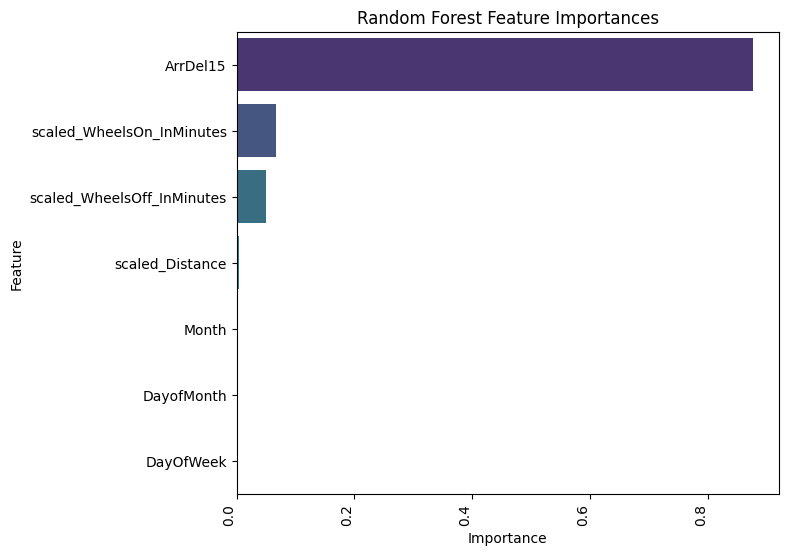

In [ ]:
importances = feature_importance_df['Importance']

sorted_idx = importances.argsort()[::-1]
sorted_features = feature_importance_df['Column_Name'].iloc[sorted_idx]
sorted_importances = importances.iloc[sorted_idx]

plt.figure(figsize=(7, 6))
sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
plt.xticks(rotation=90, ha='right')  # Aggiungi questa linea per ruotare i nomi delle features
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## EVALUATING OVERFITTING: TRAIN ERROR AND TEST AND LEARNING CURVES




In [ ]:
%time

train_predictions = modelrf.transform(trainingData)
test_predictions = modelrf.transform(testData)

# >>>>> EVALUATION ON TRAIN
evaluator_train = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
rmse_train = evaluator_train.evaluate(train_predictions)

# >>>>> EVALUATION ON TEST
evaluator_test = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
rmse_test = evaluator_test.evaluate(test_predictions)

# >>>>> RMSE PERFORMANCES
print(f"Root Mean Squared Error (RMSE) on training data: {rmse_train}")
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_test}")

# >>>>> R^2 PERFORMANCES
r2_train = evaluator_train.setMetricName("r2").evaluate(train_predictions)
r2_test = evaluator_test.setMetricName("r2").evaluate(test_predictions)

print(f"Coefficient of Determination (R^2) on training data: {r2_train}")
print(f"Coefficient of Determination (R^2) on test data: {r2_test}")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Root Mean Squared Error (RMSE) on training data: 0.009480283555361119
Root Mean Squared Error (RMSE) on test data: 0.009570733854052023
Coefficient of Determination (R^2) on training data: 0.32639317870125206
Coefficient of Determination (R^2) on test data: 0.3232338800436738


In [ ]:
# %time
# train_sizes = np.linspace(0.1, 1.0, 10)

# train_errors = []
# test_errors = []

# for train_size in train_sizes:
#     subset_train = trainingData.sample(False, train_size, seed=42)

#     model_rf=rf_regr.fit(subset_train)

#     train_predictions = model_rf.transform(subset_train)

#     test_predictions = model_rf.transform(testData)

#     evaluator = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
#     train_rmse = evaluator.evaluate(train_predictions)
#     test_rmse = evaluator.evaluate(test_predictions)

#     train_errors.append(train_rmse)
#     test_errors.append(test_rmse)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_errors, label="Train RMSE")
# plt.plot(train_sizes, test_errors, label="Test RMSE")
# plt.title("Learning Curve")
# plt.xlabel("Training Set Size")
# plt.ylabel("Root Mean Squared Error (RMSE)")
# plt.legend()
# plt.show()


# GRADIENT BOOSTING

## PARAMGRIDBUILDER

We also implement in this case a process of optimization of the optimal parameters for our Gradient boosting Regressor. The parameters taken into account are maxdepth, maxIter:

- maxdepth which controls the depth of the trees, the deeper the greater the computational cost. We try to find a middle way between efficiency and effectiveness;
- maxIter controls the maximum number of iterations of the data model;

In [ ]:
# %time
# X_y_train = X_y_train.drop("assemblerfeatures")

# from pyspark.ml.regression import GBTRegressor
# GB_regr = GBTRegressor(featuresCol="assemblerfeatures", labelCol="scaled_DepDelay", predictionCol='pred_score')

# pipeline_preprocessing = Pipeline(stages=[vectorassembler])
# pipeline_with_GB = Pipeline(stages=[pipeline_preprocessing, GB_regr])

# # anche in questa istanza, provvediamo a definire la griglia di iperparametri da ottimizzare.
# # Per una ragione di limitatezza computazionale, conveniamo nel testarne pochi.
# # Per prevenire il fenomeno dell'overfitting implementiamo il tutto attraverso la crossvalidation a 3 stadi
# param_grid = ParamGridBuilder() \
#     .addGrid(GB_regr.maxDepth, [7, 10, 15]) \
#     .addGrid(GB_regr.maxIter , [ 20, 40]) \
#     .build()

# # Inizializza l'oggetto CrossValidator
# cross_validator = CrossValidator(estimator=pipeline_with_GB,
#                                  estimatorParamMaps=param_grid,
#                                  evaluator=RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse"),
#                                  numFolds=3,
#                                  seed=42)

# cv_model = cross_validator.fit(X_y_train)
# best_model = cv_model.bestModel

# # Mostra i parametri ottimi
# best_params = best_model.stages[-1].extractParamMap()
# for param, value in best_params.items():
#     print(f"{param.name}: {value}")


# pred_GB = best_model.transform(X_y_test)
# rmse = evaluator.evaluate(pred_GB)

# print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")


In [ ]:
# best_params = best_model.stages[-1].extractParamMap()
# for param, value in best_params.items():
#     print(f"{param.name}: {value}")

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor

vector_assembler = VectorAssembler(inputCols=['Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15', 'scaled_Distance', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes'], outputCol='assemblerfeature')

preprocessing_pipeline = Pipeline(stages=[vector_assembler])
pipeline_model = preprocessing_pipeline.fit(X_y_train)

X_y_train_transformed = pipeline_model.transform(X_y_train)
X_y_test_transformed = pipeline_model.transform(X_y_test)

# >>>>> Model
gbt_regr = GBTRegressor(featuresCol="assemblerfeature", labelCol="scaled_DepDelay", predictionCol='pred_score')

pipeline_with_gbt = Pipeline(stages=[gbt_regr])
model = pipeline_with_gbt.fit(X_y_train_transformed)

# >>>>> Predictions
pred_GB = model.transform(X_y_test_transformed)


In [ ]:
%time
from pyspark.ml.evaluation import RegressionEvaluator

# >>>>> RMSE
evaluator_rmse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
rmse = evaluator_rmse.evaluate(pred_GB)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

# >>>>> R^2
evaluator_r2 = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="r2")
r2 = evaluator_r2.evaluate(pred_GB)
print(f"Coefficient of Determination (R^2) on test data: {r2}")

# >>>>> MSE
evaluator_mse = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="mse")
mse = evaluator_mse.evaluate(pred_GB)
print(f"Mean Squared Error (MSE) on test data: {mse}")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs
Root Mean Squared Error (RMSE) on test data: 0.00951331355376391
Coefficient of Determination (R^2) on test data: 0.3313301331443068
Mean Squared Error (MSE) on test data: 9.050313477222814e-05


In [ ]:
import pandas as pd

gbt_regr = model.stages[-1]
feature_importancesrf = gbt_regr.featureImportances

# >>>>> Importances
print("Feature Importances:")
for i, importance in enumerate(feature_importancesrf.toArray()):
    print(f"Feature {i}: {importance}")

feature_importance_dfrf = pd.DataFrame({
    'Column_Name': ['Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15', 'scaled_Distance', 'scaled_WheelsOff_InMinutes', 'scaled_WheelsOn_InMinutes'],
    'Importance': feature_importancesrf.toArray(),

})

print("\nFeature Importances DataFrame:")
print(feature_importance_dfrf)

Feature Importances:
Feature 0: 0.028333509266917647
Feature 1: 0.025243605310752124
Feature 2: 0.006772644902236212
Feature 3: 0.7827097916602451
Feature 4: 0.02525513998927507
Feature 5: 0.06561575288524522
Feature 6: 0.06606955598532858

Feature Importances DataFrame:
                  Column_Name  Importance
0                       Month    0.028334
1                  DayofMonth    0.025244
2                   DayOfWeek    0.006773
3                    ArrDel15    0.782710
4             scaled_Distance    0.025255
5  scaled_WheelsOff_InMinutes    0.065616
6   scaled_WheelsOn_InMinutes    0.066070


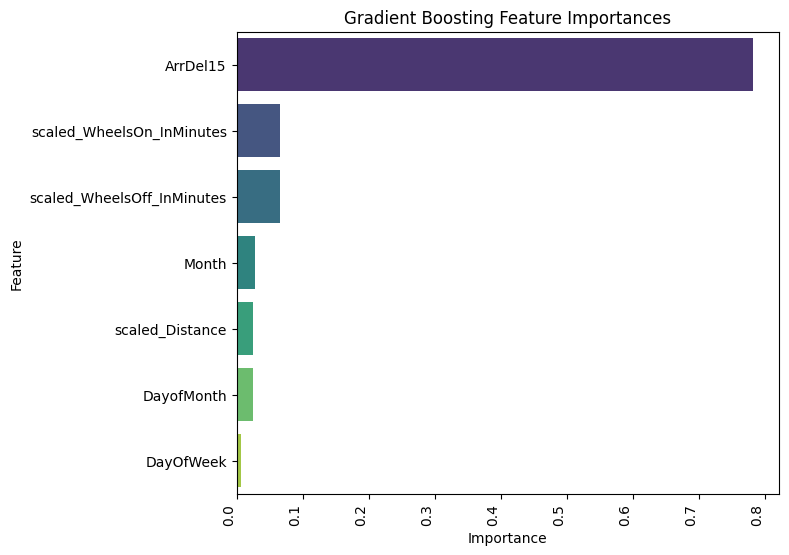

In [ ]:
importances = feature_importance_dfrf['Importance']
sorted_idx = importances.argsort()[::-1]
sorted_features = feature_importance_dfrf['Column_Name'].iloc[sorted_idx]
sorted_importances = importances.iloc[sorted_idx]

plt.figure(figsize=(7, 6))
sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
plt.xticks(rotation=90, ha='right')  # Aggiungi questa linea per ruotare i nomi delle features
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
gbt_model = model.stages[-1]
trees = gbt_model.trees

# Mostra informazioni sugli alberi decisionali
for i, tree in enumerate(trees):
    print("Tree {}: {}".format(i, tree))


Tree 0: DecisionTreeRegressionModel: uid=dtr_2b16da04a6a8, depth=5, numNodes=63, numFeatures=7
Tree 1: DecisionTreeRegressionModel: uid=dtr_2ad804f274bb, depth=5, numNodes=63, numFeatures=7
Tree 2: DecisionTreeRegressionModel: uid=dtr_044fa203c0a2, depth=5, numNodes=63, numFeatures=7
Tree 3: DecisionTreeRegressionModel: uid=dtr_db92e1e1c487, depth=5, numNodes=63, numFeatures=7
Tree 4: DecisionTreeRegressionModel: uid=dtr_1b1b2e0871c1, depth=5, numNodes=63, numFeatures=7
Tree 5: DecisionTreeRegressionModel: uid=dtr_150c76c9c496, depth=5, numNodes=63, numFeatures=7
Tree 6: DecisionTreeRegressionModel: uid=dtr_0b99d8f848da, depth=5, numNodes=61, numFeatures=7
Tree 7: DecisionTreeRegressionModel: uid=dtr_6265cb800fa9, depth=5, numNodes=63, numFeatures=7
Tree 8: DecisionTreeRegressionModel: uid=dtr_9ee10f8e20ef, depth=5, numNodes=63, numFeatures=7
Tree 9: DecisionTreeRegressionModel: uid=dtr_209e496e1906, depth=5, numNodes=63, numFeatures=7
Tree 10: DecisionTreeRegressionModel: uid=dtr_e4e4

## EVALUATING OVERFITTING: TRAIN ERROR AND TEST AND LEARNING CURVES

In [ ]:
# Lista delle colonne di interesse
feature_cols = [col for col in features if col != "scaled_DepDelay"]

# Creazione di un VectorAssembler
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='assemblerfeatures')

# Creazione del modello di regressione lineare
gb_model = GBTRegressor(labelCol="scaled_DepDelay", featuresCol="assemblerfeatures", predictionCol="prediction")

# Creazione di un pipeline
pipeline = Pipeline(stages=[vector_assembler, gb_model])

# Addestramento del modello
modelgb = pipeline.fit(X_y_train)


train_predictions = modelgb.transform(trainingData)

test_predictions = modelgb.transform(testData)


evaluator_train = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator_train.evaluate(train_predictions)

evaluator_test = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="prediction", metricName="rmse")
rmse_test = evaluator_test.evaluate(test_predictions)

# RMSE Performances
print(f"Root Mean Squared Error (RMSE) on training data: {rmse_train}")
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_test}")

# R^2 Performances
r2_train = evaluator_train.setMetricName("r2").evaluate(train_predictions)
r2_test = evaluator_test.setMetricName("r2").evaluate(test_predictions)

print(f"Coefficient of Determination (R^2) on training data: {r2_train}")
print(f"Coefficient of Determination (R^2) on test data: {r2_test}")


In [ ]:
# %time

# train_sizes = np.linspace(0.1, 1.0, 10)

# train_errors = []
# test_errors = []

# for train_size in train_sizes:
#     # Seleziona una frazione del set di addestramento
#     subset_train = trainingData.sample(False, train_size, seed=42)

#     model_GB=GB_regr.fit(subset_train)

#     train_predictions = model_GB.transform(subset_train)

#     test_predictions = model_GB.transform(testData)

#     evaluator = RegressionEvaluator(labelCol="scaled_DepDelay", predictionCol="pred_score", metricName="rmse")
#     train_rmse = evaluator.evaluate(train_predictions)
#     test_rmse = evaluator.evaluate(test_predictions)

#     train_errors.append(train_rmse)
#     test_errors.append(test_rmse)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_errors, label="Train RMSE")
# plt.plot(train_sizes, test_errors, label="Test RMSE")
# plt.title("Learning Curve")
# plt.xlabel("Training Set Size")
# plt.ylabel("Root Mean Squared Error (RMSE)")
# plt.legend()
# plt.show()